In [1]:
#Load up the required packages
library(phyloseq)
library(ggplot2)
library(vegan)
library(reshape2)
library(stringr)
library(ape)

library(dplyr)
library(data.table)

sessionInfo()

Loading required package: permute

Loading required package: lattice

This is vegan 2.5-5


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following objects are masked from ‘package:reshape2’:

    dcast, melt




R version 3.5.2 (2018-12-20)
Platform: x86_64-redhat-linux-gnu (64-bit)
Running under: Fedora 28 (Workstation Edition)

Matrix products: default
BLAS/LAPACK: /usr/lib64/R/lib/libRblas.so

locale:
 [1] LC_CTYPE=en_GB.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_GB.UTF-8        LC_COLLATE=en_GB.UTF-8    
 [5] LC_MONETARY=en_GB.UTF-8    LC_MESSAGES=en_GB.UTF-8   
 [7] LC_PAPER=en_GB.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_GB.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] data.table_1.12.2 dplyr_0.8.4       ape_5.3           stringr_1.4.0    
 [5] reshape2_1.4.3    vegan_2.5-5       lattice_0.20-38   permute_0.9-5    
 [9] ggplot2_3.2.1     phyloseq_1.26.1  

loaded via a namespace (and not attached):
 [1] pbdZMQ_0.3-3        tidyselect_0.2.5    repr_1.0.1         
 [4] purrr_0.3.3     

In [2]:
#Assuming the data is conatined in files with names matching *.biom.json 
biomlist <- list.files('Inputs/biom_files/', '*.json', full.names = T)
prj_names <- gsub('\\.biom\\.json','\\1',basename(biomlist))
nmgsdirs <- paste('./NMGS_processing_3/',prj_names, sep="")

In [3]:
#Only required if performing NMGS theta calculations
for (p in nmgsdirs)
#Create the base NMGS directory
    dir.create(p, recursive = T)


Warning message in dir.create(p, recursive = T):
“'./NMGS_processing_3/AmericanGut_ERP012803' already exists”
Warning message in dir.create(p, recursive = T):
“'./NMGS_processing_3/Atlantic_ERP012887' already exists”
Warning message in dir.create(p, recursive = T):
“'./NMGS_processing_3/CanadaWater_ERP012927' already exists”
Warning message in dir.create(p, recursive = T):
“'./NMGS_processing_3/Donna_ADSludge' already exists”
Warning message in dir.create(p, recursive = T):
“'./NMGS_processing_3/DuckWater_ERP012631' already exists”
Warning message in dir.create(p, recursive = T):
“'./NMGS_processing_3/Hydrothermal_ERP011826' already exists”
Warning message in dir.create(p, recursive = T):
“'./NMGS_processing_3/Lise_Soils' already exists”
Warning message in dir.create(p, recursive = T):
“'./NMGS_processing_3/MalawianChildren_ERP005437' already exists”
Warning message in dir.create(p, recursive = T):
“'./NMGS_processing_3/Marine_ERP013553' already exists”
Warning message in dir.create(p,

In [4]:
classify_data <- read.csv('Inputs/Taxa_Classifications_20200818_only_genus.csv', header = T, comment.char = '#', stringsAsFactors = F )
metabolic_energies <- read.csv('Inputs/Energies_with_RET.csv')

In [5]:
met_paths <- unique(classify_data$Metabolism)
names(met_paths) <- met_paths

#Build up Taxa search expressions for them
Taxa_Search_Expressions <- lapply(met_paths, FUN = function(n){
  X = classify_data[classify_data$Metabolism==n,]
  d <- apply(X, 1, function(X) paste(X[[2]],'=="',X[[1]],'"',sep=''))
  searchstr  = paste(unlist(d),collapse = ' | ')
  parse(text=searchstr)
})


In [6]:
PSobjs_full <- sapply(biomlist, function(x) import_biom(x, parseFunction = parse_taxonomy_greengenes))

Warning message in parseFunction(i$metadata$taxonomy):
“No greengenes prefixes were found. 
Consider using parse_taxonomy_default() instead if true for all OTUs. 
Dummy ranks may be included among taxonomic ranks now.”
Warning message in parseFunction(i$metadata$taxonomy):
“No greengenes prefixes were found. 
Consider using parse_taxonomy_default() instead if true for all OTUs. 
Dummy ranks may be included among taxonomic ranks now.”
Warning message in parseFunction(i$metadata$taxonomy):
“No greengenes prefixes were found. 
Consider using parse_taxonomy_default() instead if true for all OTUs. 
Dummy ranks may be included among taxonomic ranks now.”
Warning message in parseFunction(i$metadata$taxonomy):
“No greengenes prefixes were found. 
Consider using parse_taxonomy_default() instead if true for all OTUs. 
Dummy ranks may be included among taxonomic ranks now.”


In [7]:
PSobjs_full

$`Inputs/biom_files//AmericanGut_ERP012803.biom.json`
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 12886 taxa and 462 samples ]
tax_table()   Taxonomy Table:    [ 12886 taxa by 7 taxonomic ranks ]

$`Inputs/biom_files//Atlantic_ERP012887.biom.json`
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 15667 taxa and 385 samples ]
tax_table()   Taxonomy Table:    [ 15667 taxa by 7 taxonomic ranks ]

$`Inputs/biom_files//CanadaWater_ERP012927.biom.json`
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 23828 taxa and 388 samples ]
tax_table()   Taxonomy Table:    [ 23828 taxa by 7 taxonomic ranks ]

$`Inputs/biom_files//Donna_ADSludge.biom.json`
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 11585 taxa and 22 samples ]
tax_table()   Taxonomy Table:    [ 11585 taxa by 7 taxonomic ranks ]

$`Inputs/biom_files//DuckWater_ERP012631.biom.json`
phyloseq-class experiment-level object
otu_table() 

In [8]:
tt <- lapply(PSobjs_full, function(x) {unique(as.vector(tax_table(x)[,"Genus"]))})

In [9]:
write.table(unique(as.vector(unlist(tt))), "Detected_genera.tsv",sep="\t")

In [10]:
#Named list for all results
all_filtered_list = list()

for (i in seq(length(PSobjs_full))){
    curbiom = PSobjs_full[[i]]
    filtered_list <- lapply(Taxa_Search_Expressions, function(x){
                                return(tryCatch(do.call(subset_taxa, list(curbiom,x)),error=function(e) NULL))
                            })
    filtered_list = filtered_list[!sapply(filtered_list, is.null)]
    all_filtered_list[[prj_names[[i]]]] <- filtered_list
                        
}

In [11]:
allprojects <- list()
genusprojects <- list()
for (i in seq(length(all_filtered_list))){
    raw = PSobjs_full[[i]]
    genus_raw  = tax_table(raw)[!is.na(tax_table(raw)[,"Genus"]),]
    flt = all_filtered_list[[i]]
    allprojects[[names(all_filtered_list)[[i]]]] = sum(sapply(flt, function(x) sum(otu_table(x)))) / sum(otu_table(raw)) * 100
    genusprojects[[names(all_filtered_list)[[i]]]] = sum(sapply(flt, function(x) sum(otu_table(x)))) / sum(otu_table(raw)[rownames(genus_raw),]) * 100    
}
t(rbind(as.data.frame(allprojects), as.data.frame(genusprojects)))

AmericanGut_ERP012803,38.875618,70.08174
Atlantic_ERP012887,13.905109,39.59167
CanadaWater_ERP012927,11.881175,29.72283
Donna_ADSludge,18.410252,39.50700
DuckWater_ERP012631,45.669907,60.85443
Hydrothermal_ERP011826,4.765127,46.48328
Lise_Soils,10.003394,42.25596
MalawianChildren_ERP005437,52.056540,67.18932
Marine_ERP013553,43.660882,77.33934
MexicanSoil_SRP037963,19.629371,74.40627
ParkGrass_SRP044877,9.185095,36.80031


In [12]:
#Generate NMGS input files

for (i in seq(length(all_filtered_list))){
    curbiom <- all_filtered_list[[i]]
    for (x in names(curbiom)){
        outfname = paste(nmgsdirs[[i]],'/',x,'.csv', sep = '')
        write.csv(curbiom[[x]]@otu_table, outfname)
    }
}

Our actual NMGS jobs are run on a seperate HPC system, using the following Grid Engine submission script:

``` bash
#!/bin/bash
 
#$ -pe smp 4
#$ -cwd -V
#$ -q all.q,bigmem.q
#$ -l h_vmem=16g
 
fname=$1
 
bname=`basename $fname`
 
module add libs/gsl
 
if [ ! -e out_$bname.csv.csv ]
then
        ~/NMGS/C/NMGS -in $fname -out out_$bname -v -nt $NSLOTS -lm
fi
 
```



And the following code is used to pre-process the NMGS outputs


``` R
library(plyr)
library(NMGS)

dirlist = gsub('\\.\\/\\/?','',list.dirs(path = './', ))[-1]

allsets <- list()


for (dir in dirlist){
  curset <- list()
  curset\$dirname = dir
  for (f in list.files(dir, 'out*')){
    nmgs_res <- read_nmgs(paste(dir,f,sep='/'))
    theta <- nmgs_posterior_summaries(nmgs_res, burnin = 25000, thinning = 10)["theta","median"]
    type = gsub("out_(.*)\\.csv\\.csv","\\1",f)
    curset[type] = theta
  }
  save(curset, file=paste('results_',dir,'.RData', sep=""))
  allsets[[dir]] = curset
}


save(allsets, file="allsets.save.RData")

flist = list.files('./', 'results.*')
prjlist = gsub('results_(.*)\\.RData','\\1',flist)
for (f in flist){
  load(f)
  allsets[[gsub('results_(.*)\\.RData','\\1',f)]] <- curset
}

fullresults <- rbind.fill(lapply(allsets, data.frame))

fullresults[fullresults==0]=NA

fullresults\$biome = c("Human","Marine","Freshwater","WWT","Freshwater","Volcanic","Marine", "Human","Marine","Soil","Soil","WWT","Marine", "Volcanic")
fullresults\$sample = c("American Gut","Atlantic", "Canadian lakes", "Anaerobic sludge", "Farm water", "Hydrothermal vent", "Arctic soil", "Malawian children", "Baltic", "Mexican soil","Canadian parks", "Severn Trent WWT", "TARA Ocean Survey", "Italian Volcanoes")

fullresults
write.table(fullresults, 'metacommunity_diversity_20180703.txt',sep="\t");




 ```

In [13]:
#Set up the plot axes - for log scales
xbreaks = c(seq(0.001,0.01,0.001),seq(0.01,0.1,0.01), seq(0.1,1,0.1), seq(1,10,1), seq(10,100,10), seq(100,1000,100),seq(1000,10000,1000))
xlabs <- c("0.001",rep("",9),"0.01",rep("",9),"0.1",rep("",9),"1",rep("",9), "10", rep("",9), "100", rep("",9), "1000", rep("",9))

ybreaks = c(seq(0.1,1,0.1),seq(1,10,1), seq(10,100,10), seq(100,1000,100), seq(1000,10000,1000))
ylabs <- c("0.1",rep("",9),"1",rep("",9),"10",rep("",9),"100",rep("",9),"1000",rep("",9))

#Metabolic colours
metab_color_list <-  c("wheat3", "blue","red", "chartreuse3",
                       "darkgoldenrod2","orange","darkred", "purple",
                       "darkgreen", "yellow4", "steelblue3","firebrick2",
                       "indianred", "darkolivegreen4", "honeydew4","cyan", "black")
names(metab_color_list) <- metabolic_energies$Metabolism
metab_label_list = as.character(metabolic_energies$Name)
names(metab_label_list) <- names(metab_color_list)


#Per study labels and colors
study_info_df <- data.frame(
    study=c('AmericanGut_ERP012803', 'Atlantic_ERP012887', 'CanadaWater_ERP012927', 'Donna_ADSludge', 'DuckWater_ERP012631', 'Hydrothermal_ERP011826', 'Lise_Soils', 'MalawianChildren_ERP005437', 'Marine_ERP013553', 'MexicanSoil_SRP037963', 'ParkGrass_SRP044877', 'SevernTrent', 'TARA_ERP001736', 'Volcanic_ERP010094'),
    biome = c("Human","Marine","Freshwater","WWT","Freshwater","Volcanic","Soil", "Human","Marine","Soil","Soil","WWT","Marine", "Volcanic"),
    studylabel = c("American Gut","Atlantic", "Canadian lakes", "Anaerobic sludge", "Farm water", "Hydrothermal vent", "Arctic soil", "Malawian children", "Baltic", "Mexican soil","Canadian parks", "Severn Trent WWT", "TARA Ocean Survey", "Italian Volcanoes")
)

study_name_list = as.character(study_info_df$studylabel)
names(study_name_list) <- as.character(study_info_df$study)
study_biome_list = as.character(study_info_df$biome)
names(study_biome_list) <- as.character(study_info_df$study)
biome_color_list <- c("salmon3","darkseagreen","cornflowerblue","bisque3","darkorange","darkslategray")
names(biome_color_list) <- c("Human", "Marine", "Freshwater", "WWT", "Volcanic", "Soil")


#Carbon source colors + labels
c_src_colours = c("blue","orange")
names(c_src_colours) = c("C","S")

c_src_labels = c("Complex","Simple")
names(c_src_colours) = c("C","S")


# Phylogenetic diversity by Faith's distance


In [14]:
#Load the tree
gg_tree = read_tree_greengenes('Inputs/gg_13_5_otus_99_annotated.tree')
knowntips = gg_tree$tip.label

#load the database entries
gg_dat = read.table('Inputs/gg_13_5_taxonomy.txt', sep="\t", header=F, stringsAsFactors = F)
colnames(gg_dat) <- c("taxid","taxstr")
tree_dat = gg_dat[gg_dat$taxid %in% knowntips,]

In [15]:
m = match(gg_tree$tip.label, rownames(tree_dat))
prunetips = gg_tree$tip.label[is.na(head(m))]
length(prunetips)

taxdf = as.data.frame(t(as.data.frame(strsplit(gsub('.__', '', as.character(tree_dat$taxstr)), ';'), stringsAsFactors=FALSE)), stringsAsFactors=FALSE)
colnames(taxdf) <- c("Kingdom","Phylum","Class","Order","Family","Genus","Species")
taxdf$taxid <- tree_dat$taxid
rownames(taxdf) <- taxdf$taxid

cleantaxfs = sapply(taxdf,function(x) gsub(' ','',x))

cleandf = data.frame(cleantaxfs, stringsAsFactors = F)
rownames(cleandf) = rownames(taxdf)

#Get lists of tip labels we need to search for
tax_groups = lapply(Taxa_Search_Expressions, function(x) rownames(subset(cleandf, eval(x))))

sapply(tax_groups, length)
sum(sapply(tax_groups, length))

ul = unique(unlist(tax_groups))
m = match(gg_tree$tip.label, ul, )
prunelist = gg_tree$tip.label[is.na(m)]

nvec=names(tax_groups)
names(nvec)=nvec
all_prune_taxa = lapply(nvec, function(x) unique(unlist(tax_groups[-which(nvec == x)])))

working_tree = drop.tip(gg_tree, prunelist)

all_trees = lapply(all_prune_taxa, function(x) drop.tip(working_tree,x))

pd_list = lapply(all_trees, function(x) sum(x$edge.length))
pd_df = as.data.frame(t(data.frame(pd_list)))
pd_df[,2] = rownames(pd_df)
colnames(pd_df) <- c("pd","metab")

fulldf = merge(metabolic_energies, pd_df, by.x="Metabolism", by.y="metab")
pd_fulldf <- fulldf[order(fulldf$yield, decreasing = T),]

pd_fulldf 

[1] 169543

AerobicResp             Ferm      Fe_oxidizer              SOB 
           33518            22918               71              502 
          ANAMOX           SRB_H2    FeIII_reducer          SRB_CO2 
               0               20              643              184 
     SRB_Acetate      H2_Oxidizer    H2_Methanogen   CH3_Methanogen 
              54              210              307               73 
 Acet_Methanogen     Methanotroph     Methylotroph              NOB 
             218              308               61              141 
Ammonia_Oxidizer 
             375

[1] 59603

Warning message in drop.tip(working_tree, x):
“drop all tips of the tree: returning NULL”


,Metabolism,yield,dgcat,Name,C.Source.type,pd
,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>
2,AerobicResp,13.421700,-2841.199689,Aerobic Heterotroph,C,332.50995
11,Methanotroph,1.259100,-813.333282,Methanotroph,S,3.41202
8,Ferm,0.986400,-823.833282,Fermenting Heterotroph,C,318.07332
12,Methylotroph,0.893600,-688.633282,Methylotroph,S,0.55550
7,FeIII_reducer,0.724200,-809.399534,Fe III reducer,S,11.04950
14,SOB,0.697100,-796.633282,Sulphur oxidizer,S,6.47965
16,SRB_CO2,0.247300,-99.658476,Sulphate reducer (Complete oxidation),C,3.69535
10,H2_Oxidizer,0.223200,-237.200000,Hydrogen oxidizer,S,1.73620
5,CH3_Methanogen,0.127200,-78.633320,Methylotrophic Methanogen,S,1.50586


In [16]:
pd_fits <- pd_fulldf %>% filter(pd > 0.0) %>% do(data.frame(
        yield=summary(lm(log(pd) ~ log(yield), data=.))$coefficients,
        dgcat=summary(lm(log(pd) ~ log(-dgcat), data=.))$coefficients,stringsAsFactors = F))

pd_fits$param = c("intercept","slope")

pd_fitsdf<- melt(pd_fits, id.vars = c("param")) %>% dcast(. ~ param +variable)

pd_fulldf %>% filter(pd > 0.0) -> pd2

yield=lm(log(pd) ~ log(yield), data=pd2)
dgcat=lm(log(pd) ~ log(-dgcat), data=pd2)

summary(yield)

summary(dgcat)

pd_plot_yield <- ggplot(pd_fulldf, aes(x=yield,y=pd)) + theme_bw(base_size = 18, base_family = "arial") +
 
      geom_abline(data=pd_fitsdf, aes(slope=slope_yield.Estimate, intercept=intercept_yield.Estimate), 
                  alpha=1.0, color="black",size=2) +
      
      geom_point(size=5, aes(color=Metabolism), alpha=1.0) +
      geom_point(size=2, color="LightBlue", alpha=0.8) + 
      scale_x_continuous(trans = "log", breaks=xbreaks, labels=xlabs) + 
      scale_y_continuous(trans = "log", breaks=ybreaks, labels=ylabs) +  

      #scale_color_manual(values = metab_color_list, labels = metab_label_list, name="Metabolic classification" ) +
      scale_color_manual(values = metab_color_list, labels = metab_label_list, name="Metabolic classification" ) +
      #scale_color_manual(values = c_src_colours, labels = c_src_labels, name="Anabolic C source" ) +
      xlab(expression("Growth yield : " ~ bgroup("(", over(-Delta*G[cat],Delta*G[ana]+Delta*G[dis]),")"))) +
      ylab("Phylogenetic diversity (Faith's PD)")+
      
      
      ggtitle("Phylogenetic diversity:\nMetabolism")


pd_plot_dgcat <- ggplot(pd_fulldf, aes(x=-dgcat,y=pd)) + theme_bw(base_size = 18, base_family = "arial") +
 
      geom_abline(data=pd_fitsdf, aes(slope=slope_dgcat.Estimate, intercept=intercept_dgcat.Estimate),
                  alpha=1.0, color="black", size=2) +
      
      geom_point(size=5, aes(color=Metabolism), alpha=1.0) +
      geom_point(size=2, color="LightBlue", alpha=0.8) + 
      scale_x_continuous(trans = "log", breaks=xbreaks, labels=xlabs) + 
      scale_y_continuous(trans = "log", breaks=ybreaks, labels=ylabs) +  

      scale_color_manual(values = metab_color_list, labels = metab_label_list, name="Metabolic classification" ) +
      #scale_color_manual(values = c_src_colours, labels = c_src_labels, name="Anabolic C source" ) +
      #scale_color_manual(labels = c(C="Complex", S = "Simple"), name="Anabolic C source" ) +
      #xlab(expression("Growth yield : " ~ bgroup("(", over(-Delta*G[cat],Delta*G[ana]+Delta*G[dis]),")"))) +
      xlab(expression(-Delta*G[cat] (kJmol^{-1}))) +
      ylab("Phylogenetic diversity (Faith's PD)")+
      
      ggtitle("Phylogenetic diversity:\nMetabolism") 

ggsave(paste('figures/figure_S1.png', sep=""),pd_plot_dgcat,dpi = 600,units="mm", width = 150*2, height = 100*2, limitsize = FALSE) 
ggsave(paste('figures/figure_1.png', sep=""),pd_plot_yield,dpi = 600,units="mm", width = 150*2, height = 100*2, limitsize = FALSE) 


Call:
lm(formula = log(pd) ~ log(yield), data = pd2)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.9984 -0.6037 -0.2206  0.5097  3.3024 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   2.4667     0.5016   4.918 0.000227 ***
log(yield)    0.4992     0.1885   2.648 0.019097 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.506 on 14 degrees of freedom
Multiple R-squared:  0.3337,	Adjusted R-squared:  0.2861 
F-statistic: 7.013 on 1 and 14 DF,  p-value: 0.0191



Call:
lm(formula = log(pd) ~ log(-dgcat), data = pd2)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.9945 -0.6680 -0.2017  0.4616  3.2585 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept)  -1.1348     1.1763  -0.965    0.351  
log(-dgcat)   0.5419     0.2211   2.451    0.028 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.543 on 14 degrees of freedom
Multiple R-squared:  0.3003,	Adjusted R-squared:  0.2504 
F-statistic:  6.01 on 1 and 14 DF,  p-value: 0.02797


Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”


# Metacommunity

In [17]:
#Since there aren't any results for SRB_H2 in the studies examined we remove them from the metacommunity analysis
metabolic_energies <- metabolic_energies[-c(which(metabolic_energies$Metabolism == "SRB_H2")),] 

#Read in the results from the NMGS runs 
metadf = read.table('./Results//metacommunity_diversity_20200817.txt', sep="\t", stringsAsFactors = F)
#metabolic_energies <- metabolic_energies[-c(which(metabolic_energies$Metabolism == "SRB_H2"))]
metadf <- metadf[,c("dirname", as.character(metabolic_energies$Metabolism))]

md <- melt(metadf, value.name = "theta", variable.name = "metabolism", measure.vars = metabolic_energies$Metabolism, )

theta_df <- merge(md, metabolic_energies, by.x = "metabolism", by.y="Metabolism")
#Drop missing values
theta_df <- theta_df[(!is.na(theta_df$theta)) & (theta_df$theta > 0),]

theta_df

theta_fits <- theta_df %>% group_by(dirname) %>% do(data.frame(
    yield=summary(lm(log(theta) ~ log(yield), data=.))$coefficients,
    dgcat=summary(lm(log(theta) ~ log(-dgcat), data=.))$coefficients,stringsAsFactors = F))

theta_fits$param = c("intercept","slope")

theta_fitsdf<- melt(theta_fits, id.vars = c("dirname","param")) %>% dcast(dirname ~ param +variable)

,metabolism,dirname,theta,yield,dgcat,Name,C.Source.type
,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
2,Acet_Methanogen,Atlantic_ERP012887,2.4508165,0.067100,-31.00000,Acetoclastic Methanogen,C
3,Acet_Methanogen,CanadaWater_ERP012927,3.6562220,0.067100,-31.00000,Acetoclastic Methanogen,C
4,Acet_Methanogen,Donna_ADSludge,7.8173345,0.067100,-31.00000,Acetoclastic Methanogen,C
5,Acet_Methanogen,DuckWater_ERP012631,0.2961420,0.067100,-31.00000,Acetoclastic Methanogen,C
7,Acet_Methanogen,Lise_Soils,1.8829685,0.067100,-31.00000,Acetoclastic Methanogen,C
12,Acet_Methanogen,SevernTrent,2.9494670,0.067100,-31.00000,Acetoclastic Methanogen,C
15,AerobicResp,AmericanGut_ERP012803,468.1989960,13.421700,-2841.19969,Aerobic Heterotroph,C
16,AerobicResp,Atlantic_ERP012887,597.7549290,13.421700,-2841.19969,Aerobic Heterotroph,C
17,AerobicResp,CanadaWater_ERP012927,590.4394235,13.421700,-2841.19969,Aerobic Heterotroph,C


In [18]:
theta_fitsdf

dirname,intercept_yield.Estimate,intercept_yield.Std..Error,intercept_yield.t.value,intercept_yield.Pr...t..,intercept_dgcat.Estimate,intercept_dgcat.Std..Error,intercept_dgcat.t.value,intercept_dgcat.Pr...t..,slope_yield.Estimate,slope_yield.Std..Error,slope_yield.t.value,slope_yield.Pr...t..,slope_dgcat.Estimate,slope_dgcat.Std..Error,slope_dgcat.t.value,slope_dgcat.Pr...t..
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AmericanGut_ERP012803,2.748616,0.8154053,3.370858,1.987111e-02,-5.5712631,3.533201,-1.5768318,0.17565932,1.1043068,0.4289303,2.5745599,0.049759263,1.2851546,0.5806168,2.2134301,0.077768152
Atlantic_ERP012887,2.934500,0.5112696,5.739634,1.303439e-04,-1.9640680,1.781276,-1.1026184,0.29373208,0.6096811,0.2454601,2.4838296,0.030366463,0.7456457,0.3094721,2.4094115,0.034650533
CanadaWater_ERP012927,3.063391,0.4704205,6.512026,2.885211e-05,-1.4036333,1.683608,-0.8337056,0.42073262,0.7744119,0.2138041,3.6220619,0.003501304,0.6357711,0.3011454,2.1111767,0.056413437
Donna_ADSludge,3.145616,0.5873488,5.355619,4.589481e-04,-3.0675465,2.214996,-1.3848995,0.19944671,0.9056006,0.2764000,3.2764129,0.009584021,0.9372054,0.3892858,2.4074993,0.039410292
DuckWater_ERP012631,3.285172,0.6692573,4.908683,6.151185e-04,-1.7071603,2.126460,-0.8028180,0.44074316,0.7244171,0.2954581,2.4518440,0.034149849,0.7340834,0.3695386,1.9864865,0.075058272
Hydrothermal_ERP011826,1.844337,0.7020596,2.627039,3.921479e-02,0.9807937,2.569353,0.3817278,0.71581653,0.2415120,0.3134160,0.7705798,0.470200694,0.1064990,0.4191955,0.2540556,0.807934925
Lise_Soils,1.872250,0.6477437,2.890418,3.417016e-02,-2.6759073,2.323984,-1.1514308,0.30162197,0.6985245,0.3237521,2.1575907,0.083440598,0.7144462,0.3940875,1.8129128,0.129585671
MalawianChildren_ERP005437,2.911634,1.0134722,2.872930,6.389705e-02,-5.5513264,9.187494,-0.6042264,0.58832820,0.8919075,0.7481068,1.1922195,0.318884283,1.2878729,1.3612873,0.9460698,0.413908657
Marine_ERP013553,2.621278,0.7571057,3.462235,4.057425e-02,-0.9676516,6.771222,-0.1429065,0.89542255,0.4889836,0.5624808,0.8693337,0.448630768,0.5553407,1.0075420,0.5511836,0.619902178


# Simple carbon source TARA

In [19]:
#Set up the plot axes - for log scales
xbreaks_simple = c(seq(0.001,0.01,0.001),seq(0.01,0.1,0.01), seq(0.1,1,0.1), seq(1,10,1), seq(10,100,10), seq(100,1000,100),seq(1000,10000,1000))
xlabs_simple <- c("0.001",rep("",9),"0.01",rep("",9),"0.1",rep("",9),"1",rep("",9), "10", rep("",9), "100", "","","","500","","","","", "1000", "", rep("",9))

ybreaks_simple = c(seq(0.1,1,0.1),seq(1,10,1), seq(10,100,10), seq(100,1000,100), seq(1000,10000,1000))
ylabs_simple <- c("0.1",rep("",9),"1",rep("",9),"10","20","30","40","50","60","70","80","90","100","",rep("",9),"1000",rep("",9))

In [21]:
theta_df %>% group_by(dirname) %>% filter((dirname=="TARA_ERP001736") & C.Source.type=="S") -> simple_df 
cat("TARA simple carbon fit - yield")
summary(lm(log(theta) ~ log(yield), data=simple_df))
cat("TARA simple carbon fit - DGcat")
summary(lm(log(theta) ~ log(-dgcat), data=simple_df))

TARA simple carbon fit - yield


Call:
lm(formula = log(theta) ~ log(yield), data = simple_df)

Residuals:
       1        2        3        4        5        6        7 
 0.04781  0.76798 -0.16332  0.08189 -0.94600 -0.02216  0.23379 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   2.6892     0.2806   9.584  0.00021 ***
log(yield)    0.1876     0.1506   1.245  0.26824    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.5613 on 5 degrees of freedom
Multiple R-squared:  0.2367,	Adjusted R-squared:  0.08404 
F-statistic:  1.55 on 1 and 5 DF,  p-value: 0.2682


TARA simple carbon fit - DGcat


Call:
lm(formula = log(theta) ~ log(-dgcat), data = simple_df)

Residuals:
        1         2         3         4         5         6         7 
-0.069995  0.677922 -0.009854  0.093750 -0.935498  0.101074  0.142600 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept)   0.1856     1.4571   0.127    0.904
log(-dgcat)   0.3783     0.2400   1.576    0.176

Residual standard error: 0.5252 on 5 degrees of freedom
Multiple R-squared:  0.3319,	Adjusted R-squared:  0.1982 
F-statistic: 2.484 on 1 and 5 DF,  p-value: 0.1759


In [43]:
theta_df %>% group_by(dirname) %>% filter((dirname=="TARA_ERP001736") & (C.Source.type=="S") &(metabolism != "Methylotroph") ) -> simple_df 
cat("TARA simple carbon fit - yield - dropping Methylotrophs")
summary(lm(log(theta) ~ log(yield), data=simple_df))
cat("TARA simple carbon fit - DGcat - dropping Methylotrophs")
summary(lm(log(theta) ~ log(-dgcat), data=simple_df))

TARA simple carbon fit - yield - dropping Methylotrophs


Call:
lm(formula = log(theta) ~ log(yield), data = simple_df)

Residuals:
           1            2            3            4            5            6 
 0.006626964  0.504377858 -0.311540323 -0.235927050  0.062528158 -0.026065607 

Coefficients:
              Estimate Std. Error  t value   Pr(>|t|)    
(Intercept) 2.98443912 0.18283799 16.32286 8.2447e-05 ***
log(yield)  0.28561107 0.09090473  3.14187   0.034785 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3208384 on 4 degrees of freedom
Multiple R-squared:  0.7116361,	Adjusted R-squared:  0.6395451 
F-statistic: 9.871362 on 1 and 4 DF,  p-value: 0.03478497


TARA simple carbon fit - DGcat - dropping Methylotrophs


Call:
lm(formula = log(theta) ~ log(-dgcat), data = simple_df)

Residuals:
         1          2          3          4          5          6 
-0.1899975  0.4241745 -0.1075124 -0.1606139  0.1430752 -0.1091259 

Coefficients:
              Estimate Std. Error  t value Pr(>|t|)  
(Intercept) -0.4122248  0.7571674 -0.54443 0.615074  
log(-dgcat)  0.5054594  0.1264151  3.99841 0.016151 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2672816 on 4 degrees of freedom
Multiple R-squared:  0.7998727,	Adjusted R-squared:  0.7498409 
F-statistic: 15.98728 on 1 and 4 DF,  p-value: 0.01615145


In [41]:
theta_df

,metabolism,dirname,theta,yield,dgcat,Name,C.Source.type
,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
2,Acet_Methanogen,Atlantic_ERP012887,2.4508165,0.067100,-31.000000,Acetoclastic Methanogen,C
3,Acet_Methanogen,CanadaWater_ERP012927,3.6562220,0.067100,-31.000000,Acetoclastic Methanogen,C
4,Acet_Methanogen,Donna_ADSludge,7.8173345,0.067100,-31.000000,Acetoclastic Methanogen,C
5,Acet_Methanogen,DuckWater_ERP012631,0.2961420,0.067100,-31.000000,Acetoclastic Methanogen,C
7,Acet_Methanogen,Lise_Soils,1.8829685,0.067100,-31.000000,Acetoclastic Methanogen,C
12,Acet_Methanogen,SevernTrent,2.9494670,0.067100,-31.000000,Acetoclastic Methanogen,C
15,AerobicResp,AmericanGut_ERP012803,468.1989960,13.421700,-2841.199689,Aerobic Heterotroph,C
16,AerobicResp,Atlantic_ERP012887,597.7549290,13.421700,-2841.199689,Aerobic Heterotroph,C
17,AerobicResp,CanadaWater_ERP012927,590.4394235,13.421700,-2841.199689,Aerobic Heterotroph,C


In [22]:
theta_fits <- theta_df %>% group_by(dirname) %>% filter((dirname=="TARA_ERP001736") & C.Source.type=="S") %>% do(data.frame(
    yield=summary(lm(log(theta) ~ log(yield), data=.))$coefficients,
    dgcat=summary(lm(log(theta) ~ log(-dgcat), data=.))$coefficients,stringsAsFactors = F))

theta_fits$param = c("intercept","slope")
rownames(theta_fitsdf) <- theta_fitsdf$dirname



theta_fitsdf<- melt(theta_fits, id.vars = c("dirname","param")) %>% dcast(dirname ~ param +variable)

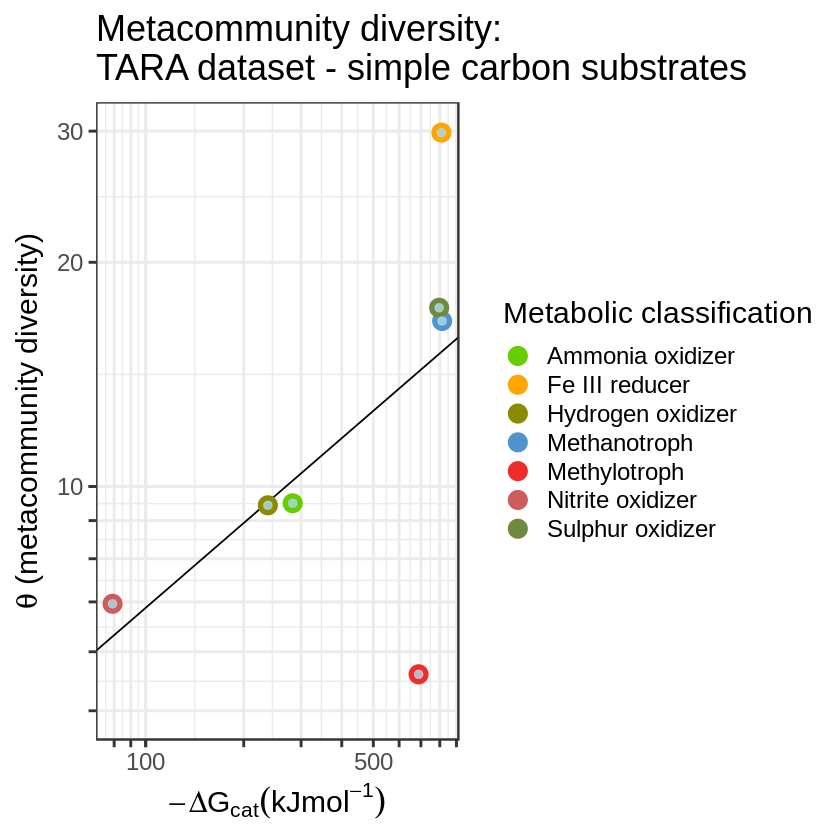

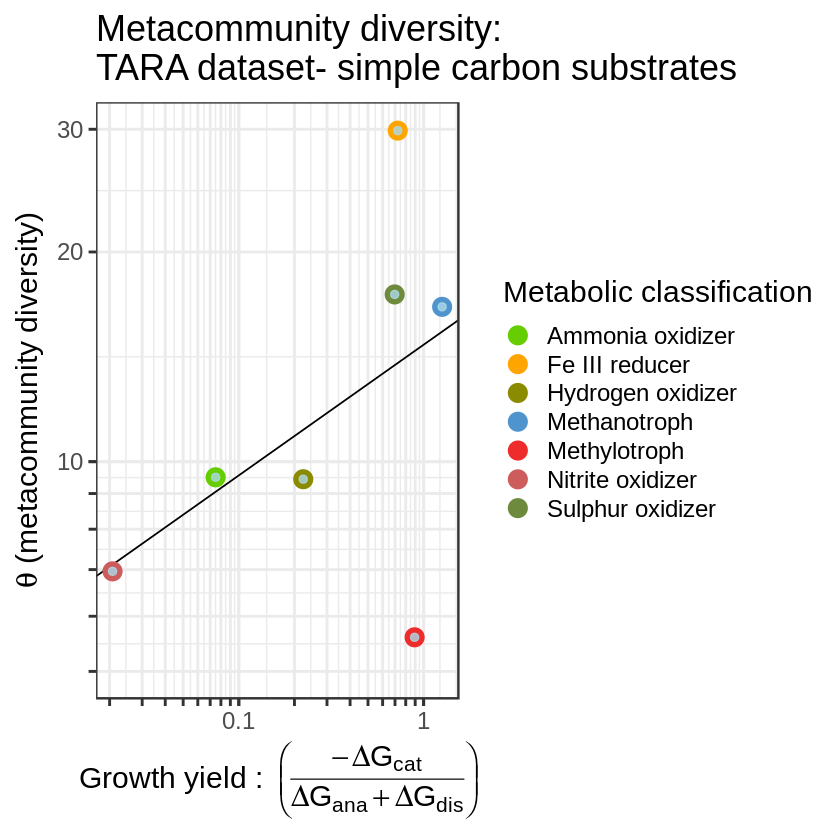

In [24]:
theta_plot_yield <- ggplot(theta_df[(theta_df$dirname=="TARA_ERP001736") & (theta_df$C.Source.type=="S"),], aes(x=yield,y=theta)) + theme_bw(base_size = 18, base_family = "arial") +
 
      geom_abline(data=theta_fitsdf[theta_fitsdf$dirname=="TARA_ERP001736",], aes(slope=slope_yield.Estimate, intercept=intercept_yield.Estimate), alpha=1.0, color="black") +
      
      geom_point(size=5, aes(color=metabolism), alpha=1.0) +
      geom_point(size=2, color="LightBlue", alpha=0.8) + 
      scale_x_continuous(trans = "log", breaks=xbreaks_simple, labels=xlabs_simple) + 
      scale_y_continuous(trans = "log", breaks=ybreaks_simple, labels=ylabs_simple, limits = c(5,30)) +  

      scale_color_manual(values = metab_color_list, labels = metab_label_list, name="Metabolic classification" ) +

      xlab(expression("Growth yield : " ~ bgroup("(", over(-Delta*G[cat],Delta*G[ana]+Delta*G[dis]),")"))) +
      ylab(expression(theta ~ "(metacommunity diversity)"))+
      
      
      ggtitle("Metacommunity diversity:\nTARA dataset- simple carbon substrates") 

theta_plot_dgcat <- ggplot(theta_df[(theta_df$dirname=="TARA_ERP001736") & (theta_df$C.Source.type=="S"),], aes(x=-dgcat,y=theta)) + theme_bw(base_size = 18, base_family = "arial") +
 
      geom_abline(data=theta_fitsdf[theta_fitsdf$dirname=="TARA_ERP001736",], aes(slope=slope_dgcat.Estimate, intercept=intercept_dgcat.Estimate), alpha=1.0, color="black") +
      
      geom_point(size=5, aes(color=metabolism), alpha=1.0) +
      geom_point(size=2, color="LightBlue", alpha=0.8) + 
      scale_x_continuous(trans = "log", breaks=xbreaks_simple, labels=xlabs_simple) + 
      scale_y_continuous(trans = "log", breaks=ybreaks_simple, labels=ylabs_simple, limits = c(5,30)) +  

      scale_color_manual(values = metab_color_list, labels = metab_label_list, name="Metabolic classification" ) +

      xlab(expression(-Delta*G[cat](kJmol^-1))) +
      ylab(expression(theta ~ "(metacommunity diversity)"))+
      
      
      ggtitle("Metacommunity diversity:\nTARA dataset - simple carbon substrates") 

ggsave('figures/figure_3.png',theta_plot_yield,dpi = 600,units="mm", width = 150*2, height = 100*2, limitsize = FALSE) 
ggsave('figures//figure_S3.png',theta_plot_dgcat,dpi = 600,units="mm", width = 150*2, height = 100*2, limitsize = FALSE) 

theta_plot_dgcat

theta_plot_yield

# Metacommunity diversity by biome

In [25]:
## Overall fit
biome_theta_df <- theta_df[(theta_df$dirname=="TARA_ERP001736") & (theta_df$C.Source.type=="S"),]
biom_yield = lm(log(theta) ~ log(yield), biome_theta_df)
biom_dgcat = lm(log(theta) ~ log(-dgcat), biome_theta_df)
    
    


summary(biom_yield)


biome_theta_df = merge(theta_df, study_info_df, by.x="dirname", by.y="study")

biome_theta_fits <- biome_theta_df %>% group_by(biome) %>% do(data.frame(
    yield=summary(lm(log(theta) ~ log(yield), data=.))$coefficients,
    dgcat=summary(lm(log(theta) ~ log(-dgcat), data=.))$coefficients,stringsAsFactors = F))

biome_theta_fits$param = c("intercept","slope")
#rownames(biome_theta_fits) <- biome_theta_fits$biome

biome_theta_fitsdf<- melt(biome_theta_fits, id.vars = c("biome","param")) %>% dcast(biome ~ param +variable)

biome_theta_fitsdf[c("biome","slope_yield.Estimate","slope_yield.Std..Error", "slope_yield.Pr...t..")]


Call:
lm(formula = log(theta) ~ log(yield), data = biome_theta_df)

Residuals:
      41       97      139      153      167      181      195 
 0.04781  0.76798 -0.16332  0.08189 -0.94600 -0.02216  0.23379 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   2.6892     0.2806   9.584  0.00021 ***
log(yield)    0.1876     0.1506   1.245  0.26824    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.5613 on 5 degrees of freedom
Multiple R-squared:  0.2367,	Adjusted R-squared:  0.08404 
F-statistic:  1.55 on 1 and 5 DF,  p-value: 0.2682


biome,slope_yield.Estimate,slope_yield.Std..Error,slope_yield.Pr...t..
<fct>,<dbl>,<dbl>,<dbl>
Freshwater,0.7509754,0.1727797,2.188835e-04
Human,1.0560983,0.3284289,9.243727e-03
Marine,0.6052185,0.1454379,2.884376e-04
Soil,1.0058884,0.1570973,2.396538e-06
Volcanic,0.4236342,0.2301590,8.861096e-02
WWT,0.9394013,0.2230039,4.280366e-04


In [26]:
mdf_casted <- dcast(biome_theta_df[,c("metabolism", "theta", "biome")], metabolism ~ biome, value.var = "theta", fun.aggregate = mean)
mdf_casted2 <-dcast(biome_theta_df[,c("metabolism", "theta", "dirname")] , metabolism ~ dirname, value.var = "theta")


In [27]:
library(Skillings.Mack)

sk_res <- Ski.Mack(as.matrix(1/mdf_casted[,-1]),simulate.p.value = T, B=100 )

sk_res


Skillings-Mack Statistic =  42.771674 , p-value =  9.3e-05 
Note: the p-value is based on the chi-squared distribution with d.f. =  14 
Based on B =  100 , Simulated p-value =  0.000000 

$Nblocks
[1] 6

$Ntreatments
[1] 15

$rawdata
          Freshwater          Human         Marine           Soil
 [1,] 0.506026266811            NaN 0.408027283968 0.531076329742
 [2,] 0.001562338224 0.002862564464 0.001874613924 0.003121161298
 [3,] 0.251138300041            NaN 0.108085287506 1.345226028240
 [4,] 0.503164274330 0.912316362120 0.791832407087            NaN
 [5,] 0.031106584792            NaN 0.057588442783 0.125362852329
 [6,]            NaN            NaN            NaN            NaN
 [7,] 0.003785625387 0.002859165130 0.004872185114 0.010197484814
 [8,] 0.079680001925 1.140303514586 0.190265177334 1.122182690220
 [9,] 0.157887534262 0.165484753869 0.052276252672 0.167152970375
[10,] 0.077709315870 0.196639857444 0.083405188061 0.200719230528
[11,] 0.677010827942            NaN 0.2

Freshwater,Human,Marine,Soil,Volcanic,WWT
0.506026266811,NaN,0.408027283968,0.531076329742,NaN,0.1857561876663
0.001562338224,0.002862564464,0.001874613924,0.003121161298,0.001523639909,0.0007357092658
0.251138300041,NaN,0.108085287506,1.345226028240,0.191113800719,0.0220208498692
0.503164274330,0.912316362120,0.791832407087,NaN,NaN,0.5893903258061
0.031106584792,NaN,0.057588442783,0.125362852329,0.271586529064,0.0566310131022
NaN,NaN,NaN,NaN,0.148376648186,NaN
0.003785625387,0.002859165130,0.004872185114,0.010197484814,0.004204138738,0.0012711554380
0.079680001925,1.140303514586,0.190265177334,1.122182690220,NaN,0.0787566917346
0.157887534262,0.165484753869,0.052276252672,0.167152970375,NaN,0.2470054601792
0.077709315870,0.196639857444,0.083405188061,0.200719230528,0.085151076423,0.1455987729518


In [29]:
biome_theta_fitsdf

biome,intercept_yield.Estimate,intercept_yield.Std..Error,intercept_yield.t.value,intercept_yield.Pr...t..,intercept_dgcat.Estimate,intercept_dgcat.Std..Error,intercept_dgcat.t.value,intercept_dgcat.Pr...t..,slope_yield.Estimate,slope_yield.Std..Error,slope_yield.t.value,slope_yield.Pr...t..,slope_dgcat.Estimate,slope_dgcat.Std..Error,slope_dgcat.t.value,slope_dgcat.Pr...t..
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Freshwater,3.164490436,0.3853738324,8.211482384,1.982534138e-08,-1.5719808335,1.281781774,-1.2264028595,0.231943988687,0.7509754215,0.1727797473,4.346431994,2.188834958e-04,0.6870023666,0.2261908442,3.037268679,5.678893633e-03
Human,2.785204236,0.5566637185,5.003387401,5.346579008e-04,-5.5866001282,2.952652681,-1.8920613875,0.087763426001,1.0560983328,0.3284288597,3.215607587,9.243726541e-03,1.2901577322,0.4635044489,2.783485110,1.933469187e-02
Marine,3.136630198,0.2830143914,11.082935332,1.495955924e-11,-1.6819571161,1.158731298,-1.4515506041,0.158147900719,0.6052185214,0.1454379453,4.161352255,2.884376145e-04,0.7325343508,0.1924918774,3.805533827,7.386270406e-04
Soil,2.535681743,0.2746167357,9.233529548,7.681301733e-09,-5.3269294164,1.529916627,-3.4818429475,0.002225603046,1.0058884241,0.1570972791,6.402965285,2.396537892e-06,1.1969076908,0.2441048549,4.903252298,7.534479667e-05
Volcanic,2.832247856,0.5431890487,5.214110747,1.669436880e-04,0.3609696174,1.856275786,0.1944590454,0.848822389494,0.4236341524,0.2301590387,1.840614885,8.861095828e-02,0.3585792041,0.3020365075,1.187204842,2.563879817e-01
WWT,3.673758607,0.4536447920,8.098315403,9.647043416e-08,-3.4346268231,1.550917762,-2.2145770112,0.038564400436,0.9394013455,0.2230039028,4.212488364,4.280365697e-04,1.0912570403,0.2701650322,4.039223846,6.418675744e-04


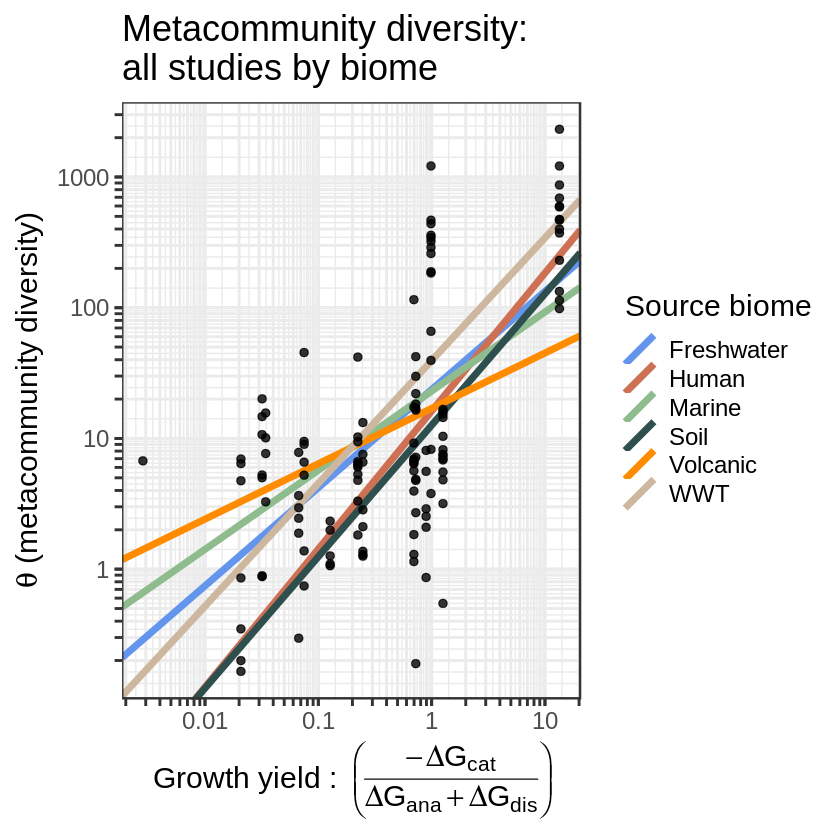

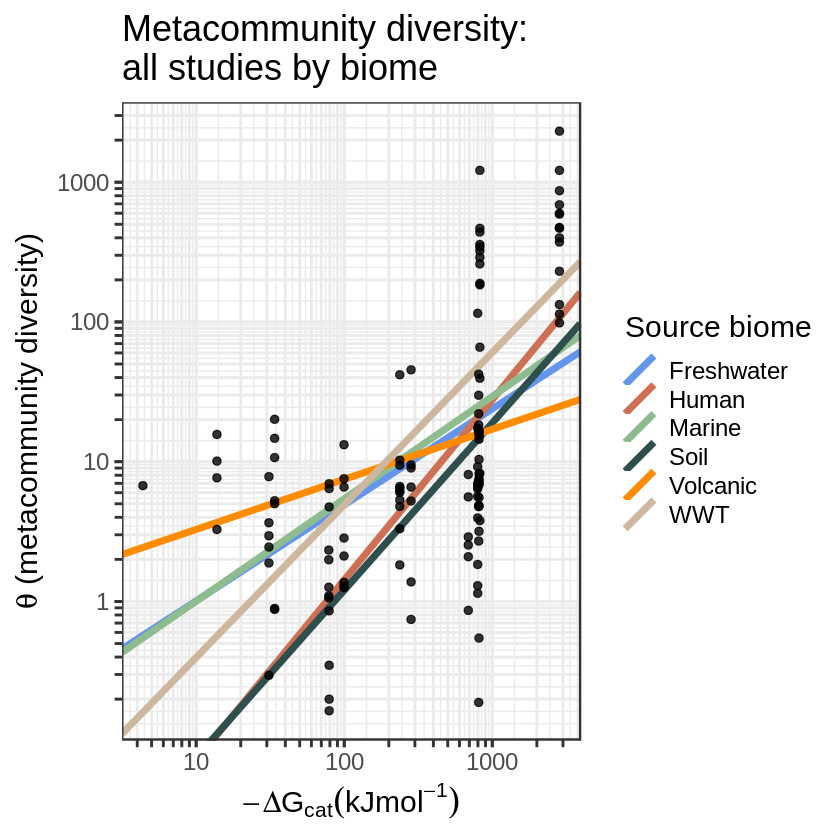

In [38]:
theta_plot_yield <- ggplot(biome_theta_df, aes(x=yield,y=theta)) + theme_bw(base_size = 18, base_family = "arial") +
 
      geom_abline(data=biome_theta_fitsdf, aes(slope=slope_yield.Estimate, intercept=intercept_yield.Estimate, color=biome),
                  alpha=1.0, size=2) +
      
      #geom_point(size=5, aes(color=biome), alpha=1.0) +
      geom_point(size=2, color="black", alpha=0.8) + 
      scale_x_continuous(trans = "log", breaks=xbreaks, labels=xlabs) + 
      scale_y_continuous(trans = "log", breaks=ybreaks, labels=ylabs) +  

      scale_color_manual(values = biome_color_list, name="Source biome" ) +

      xlab(expression("Growth yield : " ~ bgroup("(", over(-Delta*G[cat],Delta*G[ana]+Delta*G[dis]),")"))) +
      ylab(expression(theta ~ "(metacommunity diversity)"))+
      
      
      ggtitle("Metacommunity diversity:\nall studies by biome") 

theta_plot_dgcat <- ggplot(biome_theta_df, aes(x=-dgcat,y=theta)) + theme_bw(base_size = 18, base_family = "arial") +
 
      geom_abline(data=biome_theta_fitsdf, aes(slope=slope_dgcat.Estimate, intercept=intercept_dgcat.Estimate, color=biome),
                  alpha=1.0, size=2) +
      
      #geom_point(size=5, aes(color=biome), alpha=1.0) +
      geom_point(size=2, color="black", alpha=0.8) + 
      scale_x_continuous(trans = "log", breaks=xbreaks, labels=xlabs) + 
      scale_y_continuous(trans = "log", breaks=ybreaks, labels=ylabs) +  

      scale_color_manual(values = biome_color_list, name="Source biome" ) +

      xlab(expression(-Delta*G[cat](kJmol^-1)))  +
      ylab(expression(theta ~ "(metacommunity diversity)"))+
      
      
      ggtitle("Metacommunity diversity:\nall studies by biome") 


ggsave('figures/figure_2.png',theta_plot_yield,dpi = 600,units="mm", width = 150*2, height = 100*2, limitsize = FALSE) 
ggsave('figures/figure_S2.png',theta_plot_dgcat,dpi = 600,units="mm", width = 150*2, height = 100*2, limitsize = FALSE) 
theta_plot_yield
theta_plot_dgcat


In [32]:
anova(lm(log(theta) ~ log(yield)*biome, biome_theta_df))


,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
log(yield),1,222.97100873,222.971008733,87.429204278,8.464851032e-16
biome,5,16.38556502,3.277113005,1.284989398,2.751823454e-01
log(yield):biome,5,19.19097236,3.838194473,1.504995158,1.936708149e-01
Residuals,115,293.28490653,2.550303535,NA,NA


In [33]:
biome_theta_fitsdf[,c(1,2,5,10,13)][c(1,4,5,2,3)]

biome,slope_yield.Estimate,slope_yield.Pr...t..,intercept_yield.Estimate,intercept_yield.Pr...t..
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
Freshwater,0.7509754215,2.188834958e-04,3.164490436,1.982534138e-08
Human,1.0560983328,9.243726541e-03,2.785204236,5.346579008e-04
Marine,0.6052185214,2.884376145e-04,3.136630198,1.495955924e-11
Soil,1.0058884241,2.396537892e-06,2.535681743,7.681301733e-09
Volcanic,0.4236341524,8.861095828e-02,2.832247856,1.669436880e-04
WWT,0.9394013455,4.280365697e-04,3.673758607,9.647043416e-08


In [34]:
summary(lm(log(theta) ~ log(yield):biome + biome + yield , biome_theta_df))


Call:
lm(formula = log(theta) ~ log(yield):biome + biome + yield, data = biome_theta_df)

Residuals:
       Min         1Q     Median         3Q        Max 
-3.9363818 -0.8716031 -0.1316162  0.6133317  3.8929179 

Coefficients:
                              Estimate  Std. Error  t value   Pr(>|t|)    
(Intercept)                 2.56549162  0.40445447  6.34309 4.6932e-09 ***
biomeHuman                 -0.42099901  0.57875275 -0.72742 0.46845716    
biomeMarine                -0.03898635  0.48542547 -0.08031 0.93612852    
biomeSoil                  -0.63916064  0.49619237 -1.28813 0.20030890    
biomeVolcanic              -0.36966800  0.56000522 -0.66012 0.51051140    
biomeWWT                    0.47153261  0.53465073  0.88195 0.37966228    
yield                       0.18383450  0.05034886  3.65121 0.00039555 ***
log(yield):biomeFreshwater  0.49724319  0.17972583  2.76668 0.00660917 ** 
log(yield):biomeHuman       0.62272584  0.28820908  2.16067 0.03281327 *  
log(yield):biomeMarin

In [39]:
summary(lm(log(theta) ~ log(yield) , biome_theta_df))


Call:
lm(formula = log(theta) ~ log(yield), data = biome_theta_df)

Residuals:
       Min         1Q     Median         3Q        Max 
-4.4600257 -1.2206421 -0.1654962  1.1534210  4.0811991 

Coefficients:
              Estimate Std. Error  t value   Pr(>|t|)    
(Intercept) 3.03137503 0.16000421 18.94559 < 2.22e-16 ***
log(yield)  0.72900451 0.07918766  9.20604  9.882e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.622002 on 125 degrees of freedom
Multiple R-squared:  0.4040556,	Adjusted R-squared:  0.3992881 
F-statistic: 84.75112 on 1 and 125 DF,  p-value: 9.882031e-16


In [44]:
summary(lm(log(theta) ~ log(-dgcat) , biome_theta_df))


Call:
lm(formula = log(theta) ~ log(-dgcat), data = biome_theta_df)

Residuals:
       Min         1Q     Median         3Q        Max 
-4.7460374 -1.1711245 -0.2814156  1.3378973  4.0065458 

Coefficients:
              Estimate Std. Error  t value   Pr(>|t|)    
(Intercept) -2.1838077  0.6309536 -3.46112 0.00073672 ***
log(-dgcat)  0.7863984  0.1052074  7.47474 1.1791e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.746699 on 125 degrees of freedom
Multiple R-squared:  0.3089028,	Adjusted R-squared:  0.303374 
F-statistic:  55.8718 on 1 and 125 DF,  p-value: 1.17912e-11


In [36]:
summary(lm(log(theta) ~ log(yield):biome , biome_theta_df))


Call:
lm(formula = log(theta) ~ log(yield):biome, data = biome_theta_df)

Residuals:
       Min         1Q     Median         3Q        Max 
-4.5368546 -1.0983733 -0.1918109  0.9423619  4.0941251 

Coefficients:
                            Estimate Std. Error  t value   Pr(>|t|)    
(Intercept)                3.0189250  0.1588449 19.00549 < 2.22e-16 ***
log(yield):biomeFreshwater 0.7122660  0.1467545  4.85345 3.6891e-06 ***
log(yield):biomeHuman      1.0805123  0.2727414  3.96167 0.00012676 ***
log(yield):biomeMarine     0.5783443  0.1567834  3.68881 0.00033992 ***
log(yield):biomeSoil       1.0868090  0.1925092  5.64549 1.1227e-07 ***
log(yield):biomeVolcanic   0.4523320  0.1765684  2.56179 0.01165133 *  
log(yield):biomeWWT        0.7637658  0.1728553  4.41853 2.1922e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.59841 on 120 degrees of freedom
Multiple R-squared:  0.4444155,	Adjusted R-squared:  0.4166362 
F-statistic: 15.9981